In [7]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("mediabiasgroup/mbib-base", "hate-speech")
df = pd.DataFrame(dataset['train'])

/Users/antoniocastaldo/.pyenv/versions/3.10.6/envs/fake-news/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset mbib-base (/Users/antoniocastaldo/.cache/huggingface/datasets/mediabiasgroup___mbib-base/hate-speech/1.0.0/cf6f80c612f1363f2162f92f58e1113915a6b01aa07680513a18b7d94570e875)
100%|██████████| 1/1 [00:00<00:00, 126.07it/s]


In [28]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
stopwords = stopwords.words('english')

def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    removed_stopwords = ' '.join([word for word in sentence.split() if word not in stopwords])
    
    for punctuation in string.punctuation:
        sentence = removed_stopwords.replace(punctuation, '') 
    tokenized = word_tokenize(sentence)
    lemmatized = ' '.join([WordNetLemmatizer().lemmatize(word) for word in sentence.split()])
    return lemmatized

In [3]:
df['clean_txt'] = df['text'].apply(basic_cleaning)

In [4]:
df['n_words'] = df['clean_txt'].apply(lambda x: len(x.split()))

In [5]:
df['tokenized'] = df['clean_txt'].apply(word_tokenize)

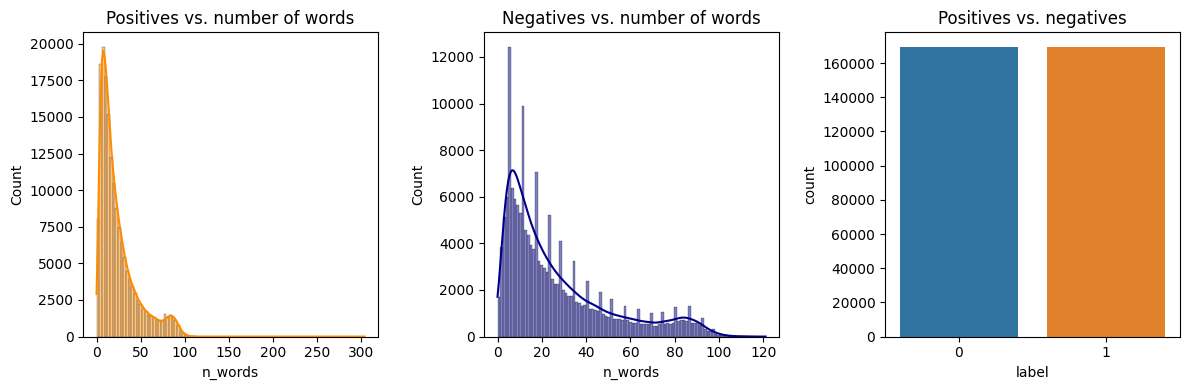

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(12, 4));  # Create subplots with 2 rows and 1 column

# Set titles for individual plots
axs[0].set_title('Positives vs. number of words');
axs[1].set_title('Negatives vs. number of words');
axs[2].set_title('Positives vs. negatives');

# Plot histograms for positives and negatives
sns.histplot(df[df.label == 1].n_words, bins=100, kde=True, ax=axs[0], color='darkorange');
sns.histplot(df[df.label == 0].n_words, bins=100, kde=True, ax=axs[1], color='darkblue');
sns.countplot(x='label', data=df, ax=axs[2]);

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

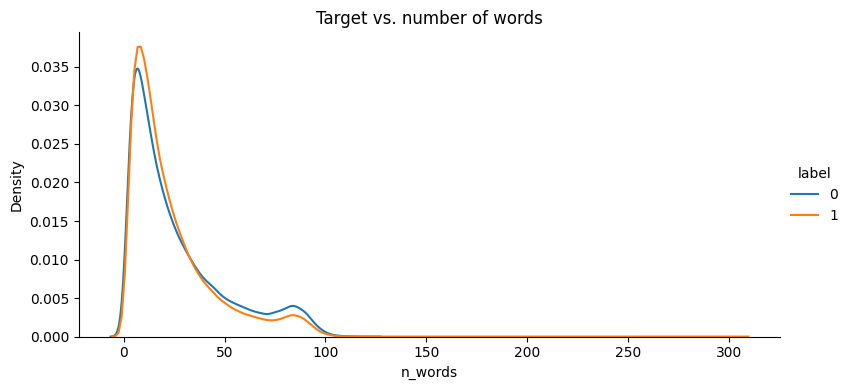

In [7]:
grid = sns.FacetGrid(df, hue="label", height=4, aspect=2)
# Set titles for individual plots
grid.axes[0, 0].set_title('Target vs. number of words');
grid.map(sns.kdeplot, "n_words")
grid.add_legend();

In [8]:
print('The dataset contains {} rows and {} columns'.format(df.shape[0], df.shape[1]))
print('The dataset contains {} positive and {} negative rows'.format(df.label.sum(), (1 - df.label).sum()))
print('The average number of words in the text is {:.0f}'.format(df.n_words.mean()))
print('The maximum number of words in the text is {:.0f}'.format(df.n_words.max()))
print('The minimum number of words in the text is {:.0f}'.format(df.n_words.min()))

The dataset contains 339010 rows and 5 columns
The dataset contains 169505 positive and 169505 negative rows
The average number of words in the text is 25
The maximum number of words in the text is 304
The minimum number of words in the text is 0


(-0.5, 799.5, 399.5, -0.5)

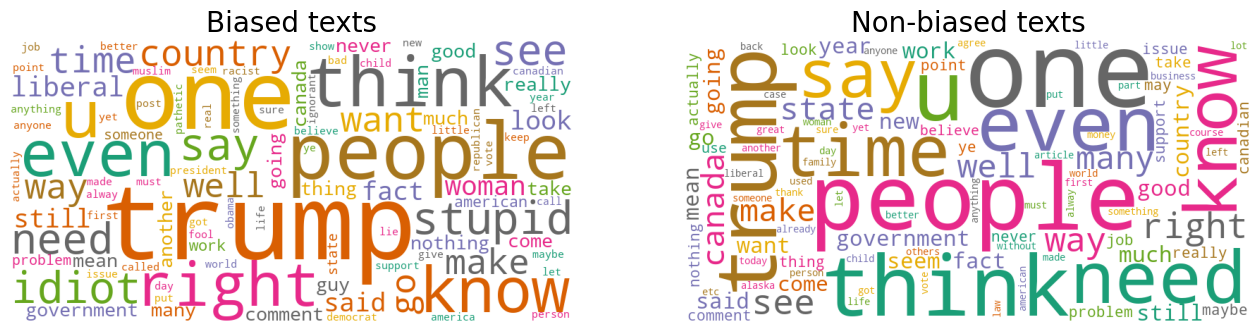

In [9]:
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap

# Create a wordcloud for positive and negative texts
pos_text = ' '.join(df[df.label == 1].clean_txt)
neg_text = ' '.join(df[df.label == 0].clean_txt)
wc = WordCloud(stopwords=STOPWORDS, background_color='white', colormap='Dark2', max_font_size=150, random_state=42, width=800, height=400, max_words=100).generate(pos_text)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wc.generate(pos_text))
plt.title('Biased texts', fontsize=20)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wc.generate(neg_text))
plt.title('Non-biased texts', fontsize=20)
plt.axis('off')

In [10]:
def print_topics(lda_model, vectorizer, top_words):
    # 1. TOPIC MIXTURE OF WORDS FOR EACH TOPIC
    topic_mixture = pd.DataFrame(
        lda_model.components_,
        columns = vectorizer.get_feature_names_out()
    )
    
    # 2. FINDING THE TOP WORDS FOR EACH TOPIC

    ## Number of topics
    n_components = topic_mixture.shape[0]

    ## Top words for each topic
    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")

        topic_df = topic_mixture.iloc[topic]\
            .sort_values(ascending = False).head(top_words)
        
        print(round(topic_df,3))

In [2]:
import pickle
def save_df(df):
    pickle.dump(df, open('df.pkl', 'wb'))
    
def load_df():
    return pickle.load(open('df.pkl', 'rb'))

In [3]:
df = load_df()

In [5]:
sample = df.sample(50000, random_state=42)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = TfidfVectorizer(
    ngram_range=(2, 2)
    )
X = count_vectorizer.fit_transform(sample.clean_txt)
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
lda_model = LatentDirichletAllocation(n_components=3, n_jobs=-1, random_state=42)
lda_model.fit(X)

document_topic_mixture = lda_model.transform(X)

In [15]:
print_topics(lda_model, count_vectorizer, 5)

----------
For topic 0, here are the the top 5 words with weights:
look like       17.555
donald trump    16.928
sound like      15.300
people like     14.544
left wing       14.489
Name: 0, dtype: float64
----------
For topic 1, here are the the top 5 words with weights:
sound like     21.769
year old       19.623
look like      16.645
white house    14.445
fake news      13.638
Name: 1, dtype: float64
----------
For topic 2, here are the the top 5 words with weights:
sound like      23.811
black people    20.942
look like       17.212
donald trump    16.867
united state    15.371
Name: 2, dtype: float64


In [4]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
stopwords = stopwords.words('english')

def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    removed_stopwords = ' '.join([word for word in sentence.split() if word not in stopwords])
    
    for punctuation in string.punctuation:
        sentence = removed_stopwords.replace(punctuation, '') 
    tokenized = word_tokenize(sentence)
    lemmatized = ' '.join([WordNetLemmatizer().lemmatize(word) for word in sentence.split()])
    return lemmatized

In [8]:
dataset = load_dataset("mediabiasgroup/mbib-base", "hate-speech")
df = pd.DataFrame(dataset['train'])
df['clean_txt'] = df['text'].apply(basic_cleaning)

Found cached dataset mbib-base (/Users/antoniocastaldo/.cache/huggingface/datasets/mediabiasgroup___mbib-base/hate-speech/1.0.0/cf6f80c612f1363f2162f92f58e1113915a6b01aa07680513a18b7d94570e875)
100%|██████████| 1/1 [00:00<00:00, 247.85it/s]


In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
sample = df.sample(50000, random_state=42)
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    MultinomialNB()
)

X_train, X_test, y_train, y_test = train_test_split(
    sample.clean_txt, sample.label, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [40]:
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Define the grid of parameters
parameters = {
    'tfidfvectorizer__ngram_range': ((1, 1), (2, 2)),
    'multinomialnb__alpha': (0.1, 1)
}

# Define the objective function
def objective(trial):
    # Define the hyperparameters to optimize
    ngram_range = trial.suggest_categorical('tfidfvectorizer__ngram_range', ((1, 1), (2, 2)))
    alpha = trial.suggest_loguniform('multinomialnb__alpha', 0.1, 1)

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidfvectorizer', TfidfVectorizer(ngram_range=ngram_range)),
        ('multinomialnb', MultinomialNB(alpha=alpha))
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Evaluate the pipeline on the validation data
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=10)

# Print the results
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)


/var/folders/mm/qv0w8wcx1fq8nn3hz1mqst_40000gn/T/ipykernel_2057/1842262931.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('multinomialnb__alpha', 0.1, 1)
/Users/antoniocastaldo/.pyenv/versions/3.10.6/envs/fake-news/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/Users/antoniocastaldo/.pyenv/versions/3.10.6/envs/fake-news/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2) which is of type tuple.
  warnings.warn(message)
/var/folders/mm/

Number of finished trials: 10
Best trial: {'tfidfvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 0.9566309249480968}
Best score: 0.78


In [42]:
pipeline = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('multinomialnb', MultinomialNB(alpha=0.9566309249480968))
])

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_val, y_val, cv=5, scoring='accuracy')
print('The average accuracy is {:.2f}'.format(scores.mean()))

The average accuracy is 0.75


In [44]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7811

In [13]:
import pandas as pd
from datasets import load_dataset
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
import pickle



dataset = load_dataset("mediabiasgroup/mbib-base", "hate-speech")
df = pd.DataFrame(dataset['train'])

def preprocess(df):

    X = df.text
    y = df.label

    ### Let's tokenize the vocabulary 
    tk = Tokenizer()
    tk.fit_on_texts(X)
    vocab_size = len(tk.word_index)
    print(f'There are {vocab_size} different words in your corpus')
    X_token = tk.texts_to_sequences(X)

    ### Pad the inputs
    X_pad = pad_sequences(X_token, dtype='float32', padding='post')
    
    return X_pad, y, vocab_size

X_pad, y, vocab_size = preprocess(df)
### Let's build the neural network now
# Size of your embedding space = size of the vector representing each word
embedding_size = 100

model = Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size+1, # 16 +1 for the 0 padding
    output_dim=embedding_size, # 100
    mask_zero=True, # Built-in masking layer :)
))

model.add(layers.LSTM(20))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

es = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_pad, y, epochs=100, batch_size=64, verbose=1, validation_split=0.2, callbacks=[es])

model.save('model.h5')
model.save_weights('model_weights.h5')
history_df = pd.DataFrame(history.history)
pickle.dump(history_df, open('history_df.pkl', 'wb'))


There are 126885 different words in your corpus
